In [1]:
%run common.ipynb

In [2]:
# we use SymPy to define rules
from sympy import Symbol, Eq, Implies, Equivalent

In [3]:
from ecbl import (
    ConceptsHeadWrapper,
    BaseHead,
    AdmissibleStatesHead,
    ConstraintsHead,
    IndependentConceptsHead,
)

/Users/andruekonst/GitHub/public/ecbl/ecbl/constraints/polytope_conversions.py:8: UserWarning: Cannot import cdd library, polytope conversions will not work
  warnings.warn('Cannot import cdd library, polytope conversions will not work')
/Users/andruekonst/GitHub/public/ecbl/ecbl/heads/constraints_head.py:24: UserWarning: Cannot import constrainet, layer_type="constrainet" will not work
  warnings.warn('Cannot import constrainet, layer_type="constrainet" will not work')


## Example Data

In [4]:
def make_labels(X):
    y_1 = (X[:, 0] >= 0.5) * 1
    y_2 = (X[:, 1] >= 0.25) * 1 + (X[:, 1] >= 0.75) * 1
    y_3 = (X[:, 0] >= 0.1) * (X[:, 1] >= 0.1) * 1 + (X[:, 0] >= 0.5) * (X[:, 1] >= 0.5) * 1
    y_0 = (y_2 == 1) & (y_1 == 1)
    return {'y_0': y_0, 'y_1': y_1, 'y_2': y_2, 'y_3': y_3}


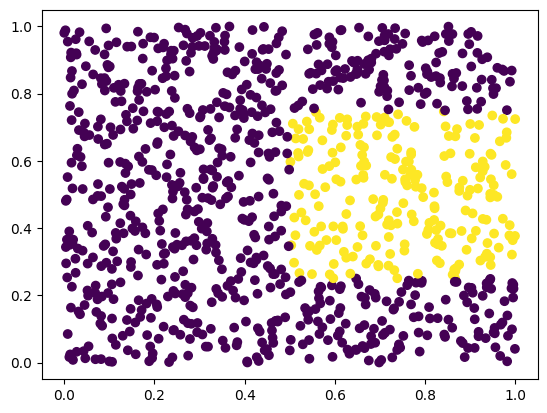

In [5]:
gen = np.random.RandomState(123)
X_train = gen.uniform(0, 1, size=(1000, 2))
ys_train =  make_labels(X_train)

X_test = gen.uniform(0, 1, size=(1000, 2))
ys_test = make_labels(X_test)


plt.scatter(*X_train.T, c=ys_train['y_0'])

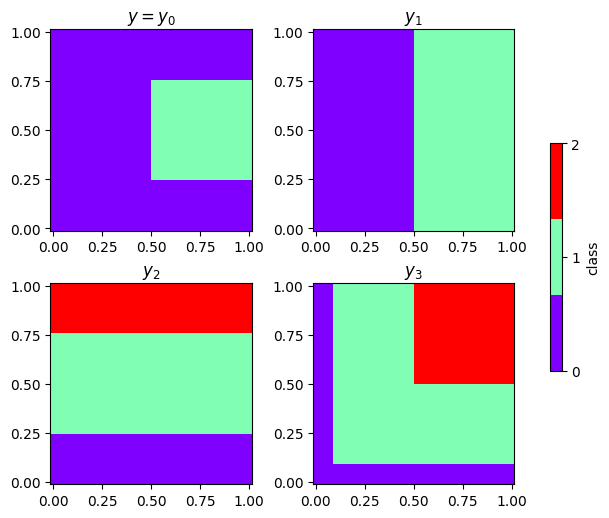

In [6]:
plot_labels(make_labels)

### Concepts

In [7]:
concepts = {
    k: len(np.unique(v))
    for k, v in ys_train.items()
}
print("Concepts (cardinalities):", concepts)

Concepts (cardinalities): {'y_0': 2, 'y_1': 2, 'y_2': 3, 'y_3': 3}


### Rules

In [8]:
rules_implication = [
    # (y_0 == 1) => ((y_2 == 1) & (y_1 == 1))
    Implies(Eq(Symbol('y_0'), 1), Eq(Symbol('y_2'), 1) & Eq(Symbol('y_1'), 1)),
]

rules_implication_2 = [
    # ((y_2 == 1) & (y_1 == 1)) => (y_0 == 1)
    Implies(Eq(Symbol('y_2'), 1) & Eq(Symbol('y_1'), 1), Eq(Symbol('y_0'), 1)),
]

rules_equivalence = [
    # ((y_2 == 1) & (y_1 == 1)) <=> (y_0 == 1)
    Equivalent(Eq(Symbol('y_2'), 1) & Eq(Symbol('y_1'), 1), Eq(Symbol('y_0'), 1)),
]


## Models

In [9]:
def make_encoder(n_hidden: int, n_layers: int = 3):
    layers = [torch.nn.Linear(2, n_hidden), torch.nn.ReLU()]
    for i in range(1, n_layers):
        layers.extend((torch.nn.Linear(n_hidden, n_hidden), torch.nn.ReLU()))
    encoder = torch.nn.Sequential(*layers)
    return encoder

In [10]:
n_hidden = 32

model = torch.nn.Sequential(
    make_encoder(n_hidden),
    ConceptsHeadWrapper(
        in_features=n_hidden,
        concepts=concepts,
        rules=rules_implication,
        head_cls=AdmissibleStatesHead,
    )
)

100%|██████████| 500/500 [00:22<00:00, 22.29it/s]


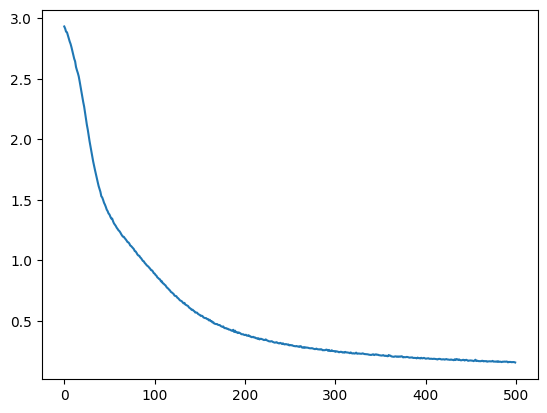

In [11]:
device = 'cpu'

dataset = NamedTensorDataset({
    'X': torch.tensor(X_train),
    # 'y_0': torch.tensor(ys_train['y_0'], dtype=torch.long),
    'y_1': torch.tensor(ys_train['y_1'], dtype=torch.long),
    'y_2': torch.tensor(ys_train['y_2'], dtype=torch.long),
    'y_3': torch.tensor(ys_train['y_3'], dtype=torch.long),
})

history = train_on_dataset(model, dataset, n_epochs=500, device=device, batch_size=32)
plt.plot(history['loss_train'])

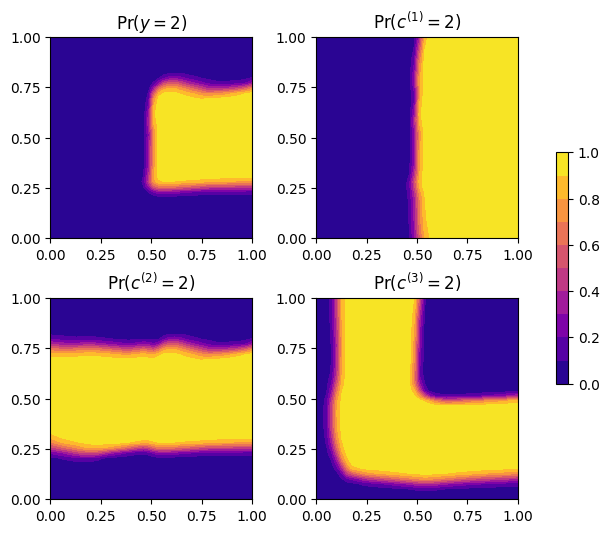

In [12]:
plot_predictions(model, device)

### Number of Rule Violations

In [13]:
from ecbl.constraints.checker import RuleChecker

In [14]:
class RuleViolationsCounter:
    def __init__(self, concepts, rules, dataset: NamedTensorDataset, device: str, batch_size: int = 32,
                 input_key: str = 'X',
                 input_dtype=torch.float):
        self.checker = RuleChecker(concepts, rules, eps=1.e-5)
        self.dataset = dataset
        self.loader = prepare_train_loader(dataset, device, batch_size=batch_size)
        self.input_key = input_key
        self.input_dtype = input_dtype
        self.accumulator = []

    def get_predictions(self, model):
        preds = defaultdict(list)
        with torch.inference_mode():
            for data in self.loader:
                for k, v in model(data[self.input_key].to(self.input_dtype).to(device)).items():
                    preds[k].append(v.cpu().numpy())
        return {
            k: np.concatenate(v, axis=0)
            for k, v in preds.items()
        }

    def estimate(self, model):
        predictions = self.get_predictions(model)
        self.accumulator.append(np.sum(~self.checker.check(predictions)))

In [15]:
unconstrained_model = torch.nn.Sequential(
    make_encoder(n_hidden),
    ConceptsHeadWrapper(
        in_features=n_hidden,
        concepts=concepts,
        rules=[],
        head_cls=IndependentConceptsHead,
    )
)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:31<00:00, 16.11it/s]


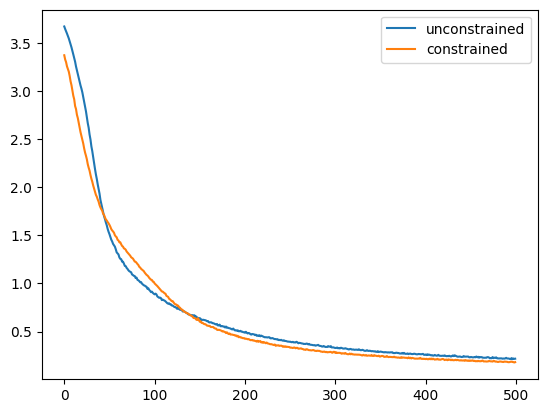

In [16]:
complete_dataset = NamedTensorDataset({
    'X': torch.tensor(X_train),
    'y_0': torch.tensor(ys_train['y_0'], dtype=torch.long),
    'y_1': torch.tensor(ys_train['y_1'], dtype=torch.long),
    'y_2': torch.tensor(ys_train['y_2'], dtype=torch.long),
    'y_3': torch.tensor(ys_train['y_3'], dtype=torch.long),
})

counter_unconstrained = RuleViolationsCounter(concepts, rules_implication, complete_dataset, device=device)
history_unconstrained = train_on_dataset(
    unconstrained_model,
    complete_dataset,
    n_epochs=500,
    device=device,
    batch_size=32,
    epoch_callback=counter_unconstrained.estimate
)

counter_constrained = RuleViolationsCounter(concepts, rules_implication, complete_dataset, device=device)
history_constrained = train_on_dataset(
    model,
    complete_dataset,
    n_epochs=500,
    device=device,
    batch_size=32,
    epoch_callback=counter_constrained.estimate
)

plt.plot(history_unconstrained['loss_train'], label='unconstrained')
plt.plot(history_constrained['loss_train'], label='constrained')
plt.legend()

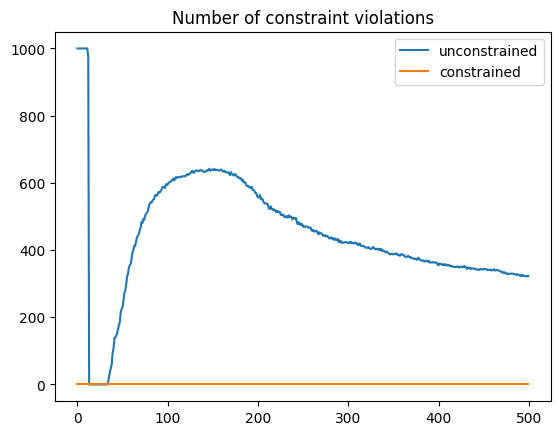

In [17]:
plt.title('Number of constraint violations')
plt.plot(counter_unconstrained.accumulator, label='unconstrained')
plt.plot(counter_constrained.accumulator, label='constrained')
plt.legend()